<a href="https://colab.research.google.com/github/educbd/ML_/blob/main/Graded_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DAB200 -- Graded Lab 3

In this lab, you will gain some experience in dealing with missing data and further practice converting non-numeric features in a dataset to numeric.

**Target**: to predict `Comb Unadj FE - Conventional Fuel`

**Data set**: make sure you use the data assigned to your group!

| Groups | Data set |
| :-: | :-: |
| 1-3 | veh14_missing.csv |
| 4-5 | veh15_missing.csv |
| 6-8 | veh16_missing.csv |
| 9-11 | veh17_missing.csv |
| 12-14 | veh18_missing.csv |
| 15-17 | veh19_missing.csv |

**Important Notes:**
- Use [Chapter 7](https://mlbook.explained.ai/bulldozer-intro.html) of the textbook as a **guide**:
     - you only need to use **random forest** models;
- Code submitted for this lab should be:
     - error free
         - to make sure this is the case, before submitting, close all Jupyter notebooks, exit Anaconda, reload the lab notebook and execute all cells
     - final code
         - this means that I don't want to see every piece of code you try as you work through this lab but only the final code; only the code that fulfills the objective
- Use the **out-of-bag score** to evaluate models
     - Read Section 5.2 carefully so that you use this method properly
     - The oob score that you provide should be the average of 10 runs
- Don't make assumptions!


### Part 0

Please provide the following information:
 - Group Number:
  - No. 14
 - Group Members:
  - Noushin Asadsamani (0829532)
  - Eduardo Chavez Barrientos (0828349)
  - Prasanna Kumar Loganathan (0827541)

     

##### Setting up the notebook:

In [ ]:
!pip install rfpimp
!pip install category_encoders

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import category_encoders as ce
from rfpimp import *

In [12]:
# Defining a function to SNIFF the data:
def sniff_mod(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['sample'] = df.iloc[0]
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['No. unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] = df.apply(lambda x: x.unique())
        return info.sort_values('data type')

# Defining a function to EVALUATE the model:
def evaluate(X, y, n_estimators=150):
    rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB score is {oob:.5f} using {n:,d} tree nodes with {h} median tree depth")
    return rf, oob

# Defining a function to show FEATURE IMPORTANCE:
def showimp(rf, X, y):
    features = list(X.columns)
    I = importances(rf, X, y, features=features)
    plot_importances(I, color='#4575b4')

### Part 1 - Create and evaluate an initial model

In this part you should:
 - use Section 7.3 of the textbook as a guide, except:
     - use all of the data; and
     - use 150 decision trees in your random forest models
 - read in the data
 - isolate all numeric features from original data set
 - fill in any missing values with 0
 - create and evaluate a baseline model

#### Code (10 marks)

In [7]:
# Read in the data:
df_raw = pd.read_csv('https://github.com/educbd/ML_/blob/main/veh18_missing.csv?raw=true')
sniff_mod(df_raw)

,sample,data type,percent missing,No. unique,unique values
# Cyl,6,int64,0.000000,8,"[6, 8, 4, 12, 3, 10, 5, 16]"
# Gears,6,int64,0.000000,8,"[6, 8, 7, 10, 9, 1, 5, 4]"
Intake Valves Per Cyl,2,int64,0.000000,2,"[2, 1]"
Exhaust Valves Per Cyl,2,int64,0.000000,2,"[2, 1]"
Eng Displ,NaN,float64,29.302326,41,"[nan, 6.2, 2.0, 4.4, 3.0, 5.2, 1.6, 2.7, 4.0, ..."
Comb Unadj FE - Conventional Fuel,26.21,float64,0.000000,1022,"[26.21, 21.8108, 35.6914, 36.7994, 18.9885, 24..."
Max Ethanol % - Gasoline,15.0,float64,2.945736,4,"[15.0, 10.0, nan, 85.0]"
Fuel Metering Sys Desc,Multipoint/sequential fuel injection,object,0.000000,5,"[Multipoint/sequential fuel injection, Spark I..."
Air Aspiration Method Desc,Naturally Aspirated,object,0.000000,4,"[Naturally Aspirated, Turbocharged, Supercharg..."
Trans Desc,XXXXX,object,0.000000,8,"[XXXXX, Semi-Automatic, Automated Manual, Manu..."


In [8]:
# Isolate all numeric features from original dataset:
df = df_raw.copy()
df = df.select_dtypes(include='number')

In [9]:
# Fill in any missing values with 0:
df = df.replace(np.nan, 0)

In [10]:
# Features X1 and target y1
X1 = df.drop('Comb Unadj FE - Conventional Fuel', axis=1)
y1 = df['Comb Unadj FE - Conventional Fuel']

In [11]:
# Create and evaluate a baseline model:
oob_scores1 = []
r2_1 = []

for i in range(10):
    model_1 = RandomForestRegressor(n_estimators = 150, n_jobs = -1, oob_score = True)
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2)
    model_1.fit(X1_train, y1_train)
    oob_scores1.append(model_1.oob_score_)
    r2_1.append(model_1.score(X1_train, y1_train))

avg_oob_scores_1 = sum(oob_scores1) / len(oob_scores1)
avg_r2_1 = sum(r2_1) / len(r2_1)
print(f"Average of oob_score over 10 runs for model_1 is: {avg_oob_scores_1:.4f}")
print(f"Average of R^2 over 10 runs for model_1 is: {avg_r2_1:.4f}")

Average of oob_score over 10 runs for model_1 is: 0.6726
Average of R^2 over 10 runs for model_1 is: 0.7524


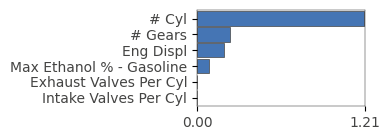

In [14]:
# Ploting the feature importance:
showimp(model_1, X1, y1)

### Part 2 - Normalize missing values

In this part you should:
 - use Section 7.4 of the textbook as a guide
 - convert **all** representations of missing data to a **single** representation

#### Code (15 marks)

In [45]:
# Taking a look to the new data
sniff_mod(df)

,sample,data type,percent missing,No. unique,unique values
# Cyl,6.00,int64,0.0,8,"[6, 8, 4, 12, 3, 10, 5, 16]"
# Gears,6.00,int64,0.0,8,"[6, 8, 7, 10, 9, 1, 5, 4]"
Intake Valves Per Cyl,2.00,int64,0.0,2,"[2, 1]"
Exhaust Valves Per Cyl,2.00,int64,0.0,2,"[2, 1]"
Eng Displ,0.00,float64,0.0,41,"[0.0, 6.2, 2.0, 4.4, 3.0, 5.2, 1.6, 2.7, 4.0, ..."
Comb Unadj FE - Conventional Fuel,26.21,float64,0.0,1022,"[26.21, 21.8108, 35.6914, 36.7994, 18.9885, 24..."
Max Ethanol % - Gasoline,15.00,float64,0.0,4,"[15.0, 10.0, 0.0, 85.0]"


#### Question (5 marks)

Note here all the different ways missing data was represented in the data.   

**Enter your answer here:**

### Part 3 - Categorical features

In this part you should:
 - use Section 7.5.1 as a guide
 - only use ordinal encoding
 - convert **all** non-numeric features to numeric
 - handle any missing values

#### Code (25 marks)

### Part 4 - Numeric features

In this part you should:
 - use Section 7.5.2 as a guide
 - handle any missing values

#### Code (30 marks)

### Part 5 - Create and evaluate a final model

In this part you should:
 - create and evaluate a model using all the features after processing them in Parts 2, 3, and 4 above

#### Code (10 marks)

#### Questions (5 marks)

Provide answers to the following:
 1. calculate the percent difference between the results of Part 1 and Part 5 (make sure you are using the correct formula for percent difference)
 2. based on the percent difference, state whether or not the results of Part 5 are an improvement over the results of Part 1

**Enter your answers here:**